# 🏺 Farsi Handwriting Recognition (OCR) using CRNN

**Project Overview:**
This notebook implements an Optical Character Recognition (OCR) system specifically tailored for **Farsi (Persian)** handwriting. 

**The Challenge:**
Farsi is a cursive script written from **Right-to-Left**, where characters change shape based on their position in a word (initial, medial, final, isolated). Standard computer vision models often struggle with these context-dependent shapes.

**The Solution:**
We use a **CRNN (Convolutional Recurrent Neural Network)** architecture. This combines:
1.  **CNNs** to extract visual features (edges, curves, dots).
2.  **RNNs (LSTMs)** to understand the sequence and context of characters.
3.  **CTC Loss** to handle the alignment between the image and the text without needing segmented character boxes.

CELL 1: Imports AND Config

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# CONFIG
BATCH_SIZE = 64
IMG_WIDTH = 128
IMG_HEIGHT = 32
MAX_LABEL_LENGTH = 16
CSV_PATH = r"/kaggle/input/shotor/Shotor_Words.csv"
IMG_FOLDER = r"/kaggle/input/shotor/Shotor_Images/Shotor_Images/"

print(f"TensorFlow Version: {tf.__version__}")

2025-12-21 15:41:48.259621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766331708.442397      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766331708.493413      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766331708.942781      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766331708.942824      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766331708.942826      24 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0


CELL 2: Preprocessing Utils

## 🛠️ Data Preprocessing Pipeline

To prepare the Farsi images for the model, we perform the following steps:

1.  **Vocabulary Construction:** We scan the dataset to build a vocabulary of all unique Farsi characters present (including special characters like 'پ', 'چ', 'ژ', 'گ').
2.  **Image Resizing with Padding:** Unlike standard resizing which distorts aspect ratio, we use `resize_with_pad`. This preserves the shape of the handwriting, which is critical for recognition.
3.  **Grayscale Conversion:** We convert images to single-channel (grayscale) to reduce computational complexity.
4.  **Matrix Transposition:** The image dimensions are swapped from `[Height, Width]` to `[Width, Height]`. This is because the RNN needs to "scan" the image column-by-column across the time axis.
5.  **Label Encoding:** Text labels are converted into sequences of integers using a `StringLookup` layer.

In [3]:
def load_data(csv_path, img_folder):
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Construct Full Image Paths
    df["full_path"] = df['image'].apply(lambda x: os.path.join(img_folder, x))
    
    # Clean Labels (Ensure they are strings)
    df['word'] = df['word'].astype(str)
    
    # Build Vocabulary (including space and special Persian chars)
    all_chars = set()
    for text in df['word'].values:
        all_chars.update(text)
        
    # Sort vocab for consistency
    vocab = sorted(list(all_chars))
    print(f"📊 Dataset Size: {len(df)}")
    print(f"🔤 Unique Characters: {len(vocab)}")
    print(f"Examples: {vocab[:10]}") # Print first few chars to verify
    
    return df, vocab

df, vocab = load_data(CSV_PATH, IMG_FOLDER)

# Create Mappings
char_to_num = layers.StringLookup(vocabulary=vocab, mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

📊 Dataset Size: 120000
🔤 Unique Characters: 35
Examples: [' ', 'آ', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ']


I0000 00:00:1766331722.156269      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
import cv2

# Filter Missing Files
df = df[df["full_path"].apply(os.path.exists)]
print(f"Valid files found: {len(df)}")

# Define the Processor
def process_sample(img_path, label):
    def load_tiff_wrapper(path):
        path = path.decode('utf-8')
        img = cv2.imread(path, 0) # Read as Grayscale
        if img is None:
            img = np.zeros((32, 128), dtype=np.uint8)
        img = np.expand_dims(img, axis=-1)
        return img

    # Wrap python function
    img = tf.numpy_function(load_tiff_wrapper, [img_path], tf.uint8)
    img.set_shape([None, None, 1]) # Essential for shape inference

    # Standard TF ops
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    img = tf.transpose(img, perm=[1, 0, 2]) # Transpose for Time-Major RNN
    
    # Label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

# Build the Dataset Pipeline
# Create basic dataset from paths/labels
dataset = tf.data.Dataset.from_tensor_slices((df['full_path'].values, df['word'].values))

# Map the processing function
dataset = dataset.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and Pad
dataset = dataset.padded_batch(
    BATCH_SIZE, 
    padded_shapes={
        "image": [IMG_WIDTH, IMG_HEIGHT, 1], 
        "label": [None] 
    },
    padding_values={
        "image": 0.0, 
        "label": tf.constant(99, dtype=tf.int64)
    }
)

# Shuffle and Split
dataset = dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_size = int(0.9 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

print(f"Train Batches: {len(train_ds)}")
print(f"Val Batches: {len(val_ds)}")

Valid files found: 120000
Train Batches: 1687
Val Batches: 188


CELL 3: CTC Layer & Model Architecture

## 🧠 Model Architecture: The CRNN

We utilize a hybrid architecture designed for sequence recognition:

### 1. Convolutional Block ( The "Eyes")
* **Layers:** Two `Conv2D` layers followed by `MaxPooling`.
* **Purpose:** These layers act as feature extractors. They look at the raw pixels and identify strokes, dots (*nokteh*), and curves that make up Farsi letters.

### 2. Recurrent Block (The "Brain")
* **Layers:** Two `Bidirectional LSTM` layers.
* **Purpose:** Farsi is cursive; the identity of a letter often depends on its neighbors. The Bidirectional LSTM looks at the sequence both forwards and backwards to understand this context.

### 3. The Output Layer (CTC)
* **Layer:** `CTCLayer` (Connectionist Temporal Classification).
* **Purpose:** Traditional classifiers need one label per image. Since our images contain whole words (sequences), CTC allows the model to predict a sequence of characters where the alignment between the image pixels and the text characters is unknown.

In [5]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        padding_token = 99
        label_length = tf.math.count_nonzero(
            tf.not_equal(y_true, padding_token), 
            axis=-1, 
            keepdims=True
        )
        label_length = tf.cast(label_length, dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [6]:
def build_model():
    # Input: (Width, Height, 1) -> Time, Features, Channels
    input_img = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # CNN Block
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool2")(x)

    # Reshape for RNN: (Width/4, Height/4 * 64)
    # We collapse Height and Channels into "Features"
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    
    x = layers.Dense(64, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN Block (Bidirectional LSTM)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output (Vocab + 1 for blank token)
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense_out")(x)

    # CTC Layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = models.Model(inputs=[input_img, labels], outputs=output, name="Persian_CRNN")
    model.compile(optimizer=tf.keras.optimizers.Adam())
    return model

model = build_model()
model.summary()

Model: "Persian_CRNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool1               │ (None, 64, 16,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 64, 16,    │     18,496 │ Pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool2               │ (None, 32, 8, 64) │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Reshape (Reshape)   │ (None, 32, 512)   │          0 │ Pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 32, 64)    │     32,832 │ Reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 64)    │          0 │ Dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_out (Dense)   │ (None, 32, 37)    │      4,773 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 37)    │          0 │ label[0][0],      │
│                     │                   │            │ dense_out[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 418,405 (1.60 MB)

 Trainable params: 418,405 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

CELL 4: Training

## 🚀 Training Configuration

* **Optimizer:** `Adam` (Adaptive Moment Estimation) - chosen for its fast convergence.
* **Loss Function:** `CTC Loss` - minimizes the error between the predicted sequence probability and the ground truth text.
* **Callbacks:** `EarlyStopping` is used to prevent overfitting. If the validation loss stops improving for 3 consecutive epochs, training halts automatically.

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/10


I0000 00:00:1766331935.617124      79 cuda_dnn.cc:529] Loaded cuDNN version 91002


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 230s 97ms/step - loss: 1304.6873 - val_loss: 1109.7220
Epoch 2/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 187s 91ms/step - loss: 891.7849 - val_loss: 506.2670
Epoch 3/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 189s 91ms/step - loss: 464.6719 - val_loss: 304.7381
Epoch 4/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 186s 91ms/step - loss: 309.5367 - val_loss: 207.5305
Epoch 5/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 216s 105ms/step - loss: 230.3071 - val_loss: 147.0220
Epoch 6/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 191s 89ms/step - loss: 181.9097 - val_loss: 112.3108
Epoch 7/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 183s 88ms/step - loss: 147.3917 - val_loss: 89.8034
Epoch 8/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 196s 97ms/step - loss: 123.9764 - val_loss: 75.7154
Epoch 9/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 192s 92ms/step - loss: 108.4064 - val_loss: 59.4711
Epoch 10/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 234s 116ms/step - loss: 94.9165 - val_loss: 51.2776


In [8]:
prediction_model = models.Model(
    model.get_layer(name="image").output, 
    model.get_layer(name="dense_out").output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Greedy search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :MAX_LABEL_LENGTH]
    
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

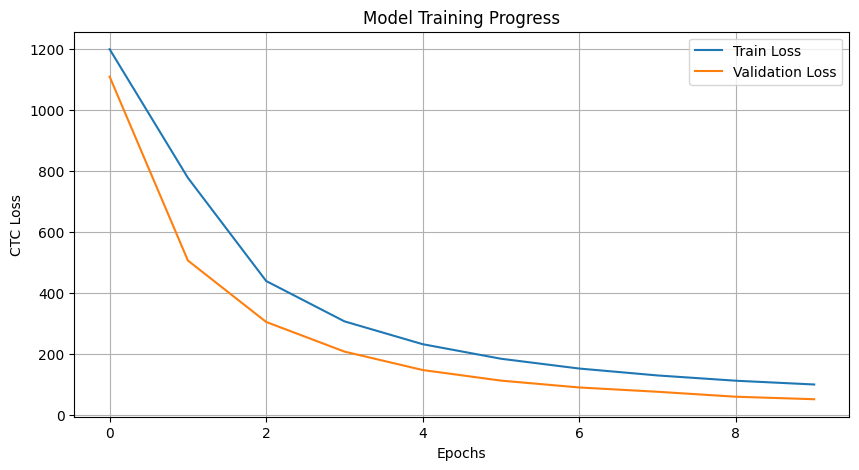

In [9]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Progress')
    plt.xlabel('Epochs')
    plt.ylabel('CTC Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run this after training finishes
plot_loss(history)

## 🔮 Inference and Decoding

The model outputs a matrix of probabilities for every time-step in the image. To convert this back into readable Farsi text, we use **CTC Decoding**:

1.  **Greedy Search:** At each time step, we take the character with the highest probability.
2.  **Collapse Repeats:** CTC often predicts the same character across multiple time steps (e.g., "aa-l-ii"). The decoder collapses these into a single character ("ali") and removes the special "blank" tokens used by CTC.
3.  **Number to Char:** Finally, the integer sequences are mapped back to their corresponding Farsi Unicode characters.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 


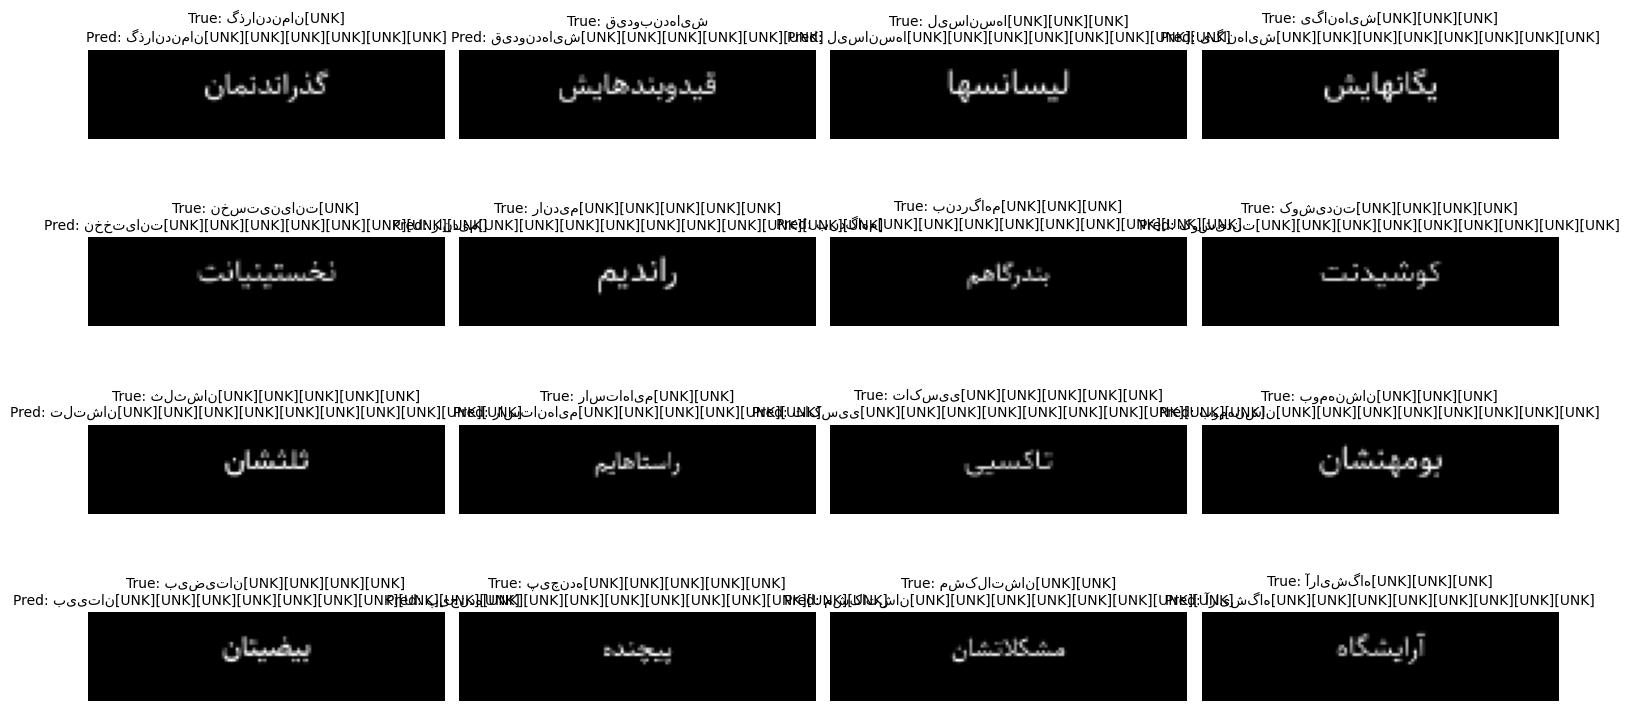

In [10]:
# Visualize a batch
def show_predictions(dataset):
    for batch in dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Get model predictions
        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        # Get true labels (convert from numbers to text)
        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        # Plot
        fig, ax = plt.subplots(4, 4, figsize=(15, 8))
        for i in range(16):
            # Transpose image back for display: (W, H, 1) -> (H, W)
            img = tf.transpose(batch_images[i], perm=[1, 0, 2])
            img = (img[:, :, 0] * 255).numpy().astype(np.uint8)

            ax[i // 4, i % 4].imshow(img, cmap="gray")
    
            title = f"True: {orig_texts[i]}\nPred: {pred_texts[i]}"
            ax[i // 4, i % 4].set_title(title, fontsize=10)
            ax[i // 4, i % 4].axis("off")
        plt.tight_layout()
        plt.show()

# Run this
show_predictions(val_ds)

In [ ]:
import json

# Save the Inference Model
# We save 'prediction_model'
# because we don't need the CTC Loss layer for real-world use.
prediction_model.save("persian_ocr_model.keras")

# Save the Vocabulary
# 'vocab' is the list of characters created in the 'load_data' function
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab, f)

print("Files saved: persian_ocr_model.keras and vocab.json")